In [1]:
import os
import sys
import glob
import scipy
import pickle
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sys.path.append('/home/mattolm/Bio_scripts/')
import StatsTools

from IPython.display import display, HTML

from Bio import SeqIO

## Load metrics (see previous notebook for details)

In [2]:
Mdb = pd.read_csv('/data1/bio_db/refseq/analysis/Manuscript/github_methods/bacterialEvolutionMetrics/DataTables/GenomeEvoMetrics.csv.gz')


In [8]:
Mdb

,Unnamed: 0,reference,querry,total_comps,failed_comps,successful_comps,considered_bases,percet_successful,N_sites,N_changed,S_sites,S_changed,dN/dS,fast_ani,counted_comps,identical_comps,expected_identicle,percent_enriched,filtered_ani,filtered_af,method,Initial divergence,Alignment size,Genome 1 size,Genome 2 size,Observed SSD,SSD 95 CI low,SSD 95 CI high,percent_expected,percent_identicle
0,0,TOBG_CPC-14.fna,TOBG_ARS-115.fna,1636,264,1372,1349279,83.863081,1.045152e+06,36790.166667,3.064563e+05,142979.833333,0.075448,89.17415,1071,6,1.127393e-24,5.602241e-01,86.672973,0.988352,oceanList,0.107042,1488349.0,2765177.0,2466433.0,5.973097,4.593316,7.743177,1.052655e-25,0.560224
1,1,TOBG_SP-259.fna,TOBG_ARS-115.fna,1662,799,863,804116,51.925391,6.210367e+05,2159.666667,1.822073e+05,8941.333333,0.070865,98.19005,618,48,4.098642e-03,7.766327e+00,98.611531,0.986317,oceanList,0.017903,1765574.0,2338586.0,2466433.0,52.239519,39.715062,68.240510,6.632107e-04,7.766990
2,2,TOBG_EAC-65.fna,TOBG_ARS-123.fna,1508,456,1052,876420,69.761273,6.563537e+05,7494.000000,2.182993e+05,22129.000000,0.112633,96.10665,768,6,4.494968e-08,7.812500e-01,96.732806,0.973083,oceanList,0.034797,1497540.0,2147286.0,1860870.0,6.806949,5.660173,8.516977,5.852823e-09,0.781250
3,3,TOBG_IN-1213.fna,TOBG_ARS-123.fna,1438,901,537,422142,37.343533,3.158287e+05,2759.500000,1.049903e+05,8002.500000,0.114631,96.45370,369,4,1.990122e-07,1.084011e+00,97.520601,0.928505,oceanList,0.030861,1423846.0,1920553.0,1860870.0,14.079823,12.274124,16.309080,5.393285e-08,1.084011
4,4,TOBG_RS-817.fna,TOBG_ARS-123.fna,1467,799,668,523867,45.535106,3.918850e+05,1827.500000,1.302320e+05,5344.500000,0.113634,98.06145,463,10,1.668181e-03,2.159467e+00,98.651356,0.970577,oceanList,0.016599,1455364.0,1985135.0,1860870.0,39.956461,34.873688,44.237461,3.602983e-04,2.159827
5,5,TOBG_SAT-195.fna,TOBG_ARS-13.fna,2991,23,2968,2892841,99.231026,2.276166e+06,531.000000,6.078122e+05,244.000000,0.581126,99.94110,2283,1832,1.213927e+03,2.707286e+01,99.976015,0.988533,oceanList,0.000261,3332031.0,3385183.0,3792666.0,1079.720870,253.345810,3203.225475,5.317243e+01,80.245291
6,6,TOBG_EAC-45.fna,TOBG_ARS-18.fna,2845,919,1926,1856800,67.697715,1.453765e+06,2354.666667,3.990680e+05,5324.333333,0.121399,98.96305,1441,1170,7.765538e-01,8.113973e+01,99.650262,0.996977,oceanList,0.010255,3231396.0,4388938.0,3711261.0,2221.030051,1867.519852,2772.125143,5.388992e-02,81.193616
7,7,TOBG_SAT-101.fna,TOBG_ARS-18.fna,2732,1002,1730,1660086,63.323572,1.299552e+06,2034.833333,3.567840e+05,4656.166667,0.119981,98.70870,1285,992,1.504506e-01,7.718674e+01,99.652619,0.996286,oceanList,0.012622,3120588.0,4047777.0,3711261.0,1690.260838,1342.720375,2060.245530,1.170822e-02,77.198444
8,8,TOBG_SP-45.fna,TOBG_ARS-18.fna,1949,1155,794,668882,40.738840,5.286442e+05,29044.833333,1.453208e+05,81255.166667,0.098261,84.82160,555,0,1.007729e-35,-1.815728e-36,83.821431,0.961112,oceanList,0.133279,1405556.0,3674042.0,3711261.0,0.575558,0.507158,0.649519,1.815728e-36,0.000000
9,9,TOBG_MED-599.fna,TOBG_ARS-28.fna,2875,1055,1820,1738652,63.304348,1.353695e+06,40641.666667,3.882762e+05,87194.333333,0.133691,91.53700,1454,1,9.072892e-19,6.877579e-02,92.810448,0.941281,oceanList,0.075421,3189775.0,4811953.0,4406224.0,0.412521,0.345620,0.475656,6.239953e-20,0.068776


## Make Figure 2 (individual plot)

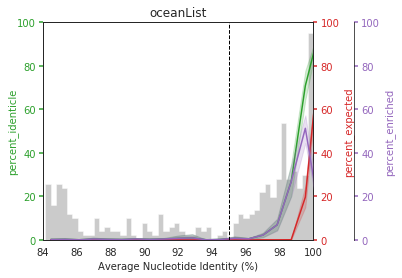

In [3]:
def dream_figure(db, met1='fast_ani', XMIN=80, limit_items=False, levels=30,
                 bw=0.15, **kwargs):
    '''
    levels = number of bins for the side lines
    bw = for plotting the homolog ani density
    '''
    sns.set_style('white')
    
    # set up
    # https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
    if 'host' in kwargs:
        host = kwargs.get('host')
    else:
        fig, host = plt.subplots()
        fig.subplots_adjust(right=0.75)
        
    # Set up fata
    df = db.copy()
    if limit_items != False:
        df = df.head(limit_items)
        
    # bin data
    extra = (100 -XMIN) / levels
    custom_bucket_array = np.linspace(XMIN - extra, 100 + extra, levels + 2)
    df[met1] = pd.cut(df[met1], custom_bucket_array)
    df = df[df[met1] == df[met1]]
    df[met1] = [fix_range(x) for x in df[met1]]
    df[met1] = df[met1].astype(float)
    
    colors = kwargs.get('colors', ['blue', 'red', 'green'])
    
    # make the histogram (v1)
    #sns.distplot(db[met1].astype(float), bins=50, ax=host, kde=False, color='blue')
    #host.set_yticks([])
    #host.set_ylabel("Number of ANI values (histogram)")
    
    # make the histogram (v2)
    #sns.kdeplot(df[met1], shade=True, color='blue', bw=bw, ax=host)
    
    # Make the hisogram (v3)
    sns.distplot(db[met1].astype(float), bins=50, ax=host, kde=False, color=colors[0],
                 hist_kws={"histtype": "stepfilled", "color": colors[0]})
    host.set_yticks([])
    
    
    # plot dn/ds
    plot_two_metric = kwargs.get('plot_two_metric', 'dN/dS')
    
    ax2 = host.twinx()
    sns.lineplot(data=df, x=met1, y=plot_two_metric, ax=ax2, err_style="band", color=colors[1])#, ci='sd')
    host.set_ylabel(plot_two_metric, labelpad=25)
    ax2.set_ylabel('')
    if 'twoLim' in kwargs:
        ax2.set_ylim(kwargs.get('twoLim'))
    
    # plot percent_enriched
    plot_three_metric = kwargs.get('plot_three_metric', 'percent_enriched')
    
    if plot_three_metric in df:
        ax3 = ax2.twinx()
        if 'threeMax' in kwargs:
            sns.lineplot(data=df[df[met1] <= kwargs.get('threeMax')], x=met1, y=plot_three_metric, ax=ax3, color=colors[2])#, ci='sd')
        else:
            sns.lineplot(data=df, x=met1, y=plot_three_metric, ax=ax3, err_style="band", color=colors[2])

        ax3.set_ylabel(plot_three_metric)
        #ax3.lines[0].set_linestyle('--')
        
        # Offset the legend
        #ax3.spines["right"].set_position(("axes", 1.15))
        
        if 'threeLim' in kwargs:
            ax3.set_ylim(kwargs.get('threeLim'))
            
    plot_four_metric = kwargs.get('plot_four_metric', 'percent_enriched')
    if plot_four_metric in df:
        ax4 = ax2.twinx()
        if 'fourMax' in kwargs:
            sns.lineplot(data=df[df[met1] <= kwargs.get('fourMax')], x=met1, y=plot_four_metric, ax=ax4, color=colors[3])#, ci='sd')
        else:
            sns.lineplot(data=df, x=met1, y=plot_four_metric, ax=ax4, err_style="band", color=colors[3])

        ax4.set_ylabel(plot_four_metric)
        #ax3.lines[0].set_linestyle('--')
        
        # Offset the legend
        ax4.spines["right"].set_position(("axes", 1.15))
        
        if 'fourLim' in kwargs:
            ax4.set_ylim(kwargs.get('fourLim'))   
    

    # Adjust ticks
    host.yaxis.label.set_color(colors[1])
    ax3.yaxis.label.set_color(colors[2])
    ax4.yaxis.label.set_color(colors[3])
    
    tkw = dict(size=4, width=1.5)
    ax2.tick_params(axis='y', colors=colors[1], **tkw)
    ax3.tick_params(axis='y', colors=colors[2], **tkw)
    ax4.tick_params(axis='y', colors=colors[3], **tkw)
    
    # Add line
    plt.axvline(95, ls='--', color='black', linewidth=1)
    
    # Adjust figure size
    plt.xlim(XMIN, 100)
    host.set_xlabel('Average Nucleotide Identity (%)')
    
    
    return host
    
def fix_range(x):
    o = float(str(x).split(',')[0][1:])
    t = float(str(x).split(',')[1][:-1])
    return float("{0:.2f}".format(np.mean([o,t])))

XMIN=84
GCdb = Mdb[Mdb['reference'] != Mdb['querry']]
GCdb = GCdb[GCdb['fast_ani'] >= XMIN]
GCdb = GCdb[GCdb['fast_ani'] <= 100]

colors = [sns.color_palette()[7]] + sns.color_palette()[2:]

twoLim = (0, 100)
threeLim = (0, 100)
fourLim = (0, 100)
fourMax = 110

for m, db in GCdb.groupby('method'):
    if m != 'oceanList':
        continue
    
    dream_figure(db[(db['fast_ani'] >= XMIN)].reset_index(), XMIN=XMIN, limit_items=False, bw=0.3,
                levels=20, twoLim=twoLim, threeLim=threeLim, fourLim=fourLim, fourMax=fourMax, colors=colors,
                plot_three_metric = 'percent_expected', threeMax=110, plot_two_metric='percent_identicle',
                twoMax=110)
    plt.title(m)
    #plt.gcf().savefig("{0}{1}_Supplemental_v7.pdf".format(fig_loc, m, XMIN), bbox_inches='tight')
    plt.show()
    break

## Make Figure 2 (all together)

In [5]:
m2m = {}
m2m['infantList'] = 'MAGs from the human microbiome'
m2m['oceanList'] = 'MAGs from the ocean'
m2m['soilList'] = 'MAGs from soil'
m2m['refseqTheta'] = 'Refseq'

Plotting refseqTheta
Plotting infantList
Plotting oceanList
Plotting soilList


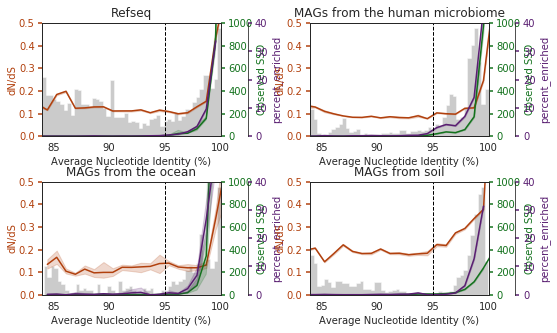

In [6]:
XMIN=84
GCdb = Mdb[Mdb['reference'] != Mdb['querry']]
GCdb = GCdb[GCdb['fast_ani'] <= 100]

twoLim = (0, 0.5)
threeLim = (0, 1000)
fourLim = (0, 40)
fourMax = 99.9

colors = [sns.color_palette()[7]] + sns.color_palette('dark')[1:3] + sns.color_palette('dark')[4:]

fig = plt.figure()

i = 0

ORDER = ['refseqTheta', 'infantList', 'oceanList', 'soilList']
for m in ORDER:
    print("Plotting {0}".format(m))
    db = GCdb[GCdb['method'] == m]
    host = plt.subplot2grid((2, 2), (int(i/2), i%2))
    
    dream_figure(db[(db['fast_ani'] >= XMIN)].reset_index(), XMIN=XMIN, limit_items=False, bw=0.3,
                levels=20, twoLim=twoLim, threeLim=threeLim, fourLim=fourLim, fourMax=fourMax, colors=colors,
                plot_three_metric = 'Observed SSD', host=host)
    
    host.set_title(m2m[m])
    i += 1
    
fig.set_size_inches(8, 5)
plt.subplots_adjust(wspace=0.5, hspace=0.4)
#plt.gcf().savefig("{0}SelectionForcesAll_v8.1.pdf".format(fig_loc, m, XMIN), bbox_inches='tight')
plt.show()

## Making Supplemental Figure S1

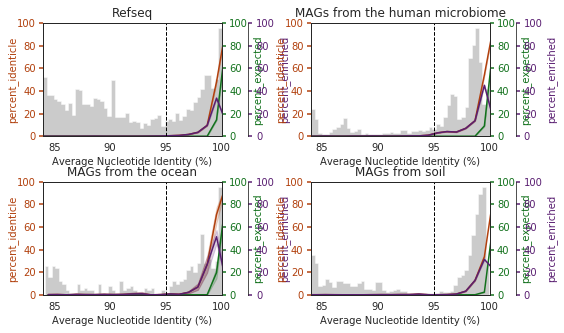

In [7]:
XMIN=84
GCdb = Mdb[Mdb['reference'] != Mdb['querry']]
GCdb = GCdb[GCdb['fast_ani'] <= 100]

twoLim = (0, 100)
threeLim = (0, 100)
fourLim = (0, 100)
fourMax = 110

colors = [sns.color_palette()[7]] + sns.color_palette('dark')[1:3] + sns.color_palette('dark')[4:]

fig = plt.figure()

i = 0

ORDER = ['refseqTheta', 'infantList', 'oceanList', 'soilList']
for m in ORDER:
    db = GCdb[GCdb['method'] == m]
    host = plt.subplot2grid((2, 2), (int(i/2), i%2))
    
    dream_figure(db[(db['fast_ani'] >= XMIN)].reset_index(), XMIN=XMIN, limit_items=False, bw=0.3,
                levels=20, twoLim=twoLim, threeLim=threeLim, fourLim=fourLim, fourMax=fourMax, colors=colors,
                plot_three_metric = 'percent_expected', threeMax=110, plot_two_metric='percent_identicle',
                twoMax=110, host=host)
    
    host.set_title(m2m[m])
    i += 1
    
fig.set_size_inches(8, 5)
plt.subplots_adjust(wspace=0.5, hspace=0.4)
#plt.gcf().savefig("{0}SelectionForcesAll_secondary_v8.1.pdf".format(fig_loc, m, XMIN), bbox_inches='tight')
plt.show()

# Note: Subsequent asthetic adjustments were made to the figures in Adobe Illustrator